In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy


In [ ]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
df = pd.read_excel('champagne_new.xlsx', index_col='Month')
df.index = pd.to_datetime(df.index)
df

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


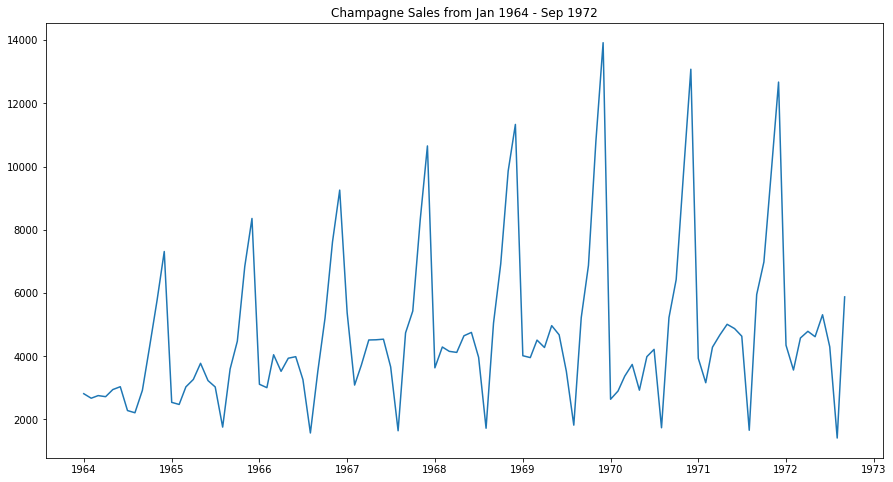

In [4]:
plt.figure(figsize=(15,8))
plt.plot(df)
plt.title("Champagne Sales from Jan 1964 - Sep 1972")
plt.show()

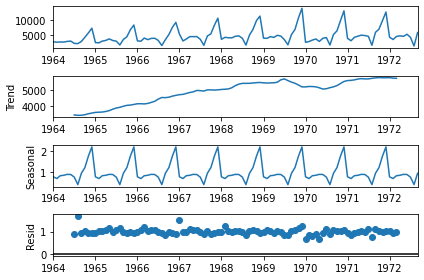

In [5]:
# Thực hiện Decomposition và trực quan hoá
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative') 
result.plot()
plt.show()

Nhận xét:
- Theo kết quả Decomposition, Champage Sales có Trend tăng từ năm 1964 đến đầu năm 1969, sau đó Trend tăng chững lại, có đi xuống và đi ngang đến năm 1972.
- Có tính Seasonal trong data Sales, gần như tăng mạnh vào cuối năm, giảm mạnh vào giữa năm. Có thể cho thấy việc bán hàng/tiêu thụ rượu bị ảnh hưởng lớn vào các mùa lễ hội cuối năm.
- Residual chỉ ra có một vào đột biến tăng vào giữa năm 1964, đầu năm 1967, và đột biến giảm và thay đổi bất thường vào năm 1970.
- Vì đây là bài toán Time-Series nên trong Machine Learning thông thường có 2 thuật toán xử lý là ARIMA và HoltWinters. Qua phân tích Decomposition ở trên, dữ liệu có tính Seasonal khá mạnh nên thông thường ARIMA sẽ xử lý tốt hơn. Vậy nên **chọn thuật toán ARIMA** cho bài toán này.


In [6]:
# Sử dụng train_test_split với Shuffle = False
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, shuffle=False, test_size=0.25)
test.head()

,monthly_champange
Month,
1970-07-01,4217
1970-08-01,1738
1970-09-01,5221
1970-10-01,6424
1970-11-01,9842


In [7]:
# Tạo model ARIMA, set m=12, các parameter khác để default
from pmdarima import auto_arima
stepwise_model = auto_arima(df, m=12)

In [8]:
print(stepwise_model.aic())

1498.1667652457852


In [29]:
# Fit data, và dự đoán y_test, đồng thời 9 tháng tiếp theo
stepwise_model.fit(train)
forcast_index = pd.date_range('1970-07-01', '1973-06-01', freq='MS').strftime('%Y-%m-%d').tolist()
future_forecast = stepwise_model.predict(n_periods=len(test)+9)
future_forecast = pd.DataFrame(future_forecast, index=forcast_index, columns=['Prediction'])
future_forecast.index = pd.to_datetime(future_forecast.index)

# Tách pred và next_9_months, để len(test)-1 cho đồ thị không bị đứt khúc
pred = future_forecast[:len(test)]
next_9_months = future_forecast[len(test)-1:]
next_9_months

,Prediction
1972-09-01,6104.874182
1972-10-01,7755.656027
1972-11-01,11683.183096
1972-12-01,14790.458868
1973-01-01,3527.287765
1973-02-01,3786.174333
1973-03-01,4257.460545
1973-04-01,4625.352353
1973-05-01,3817.605380
1973-06-01,4871.893363


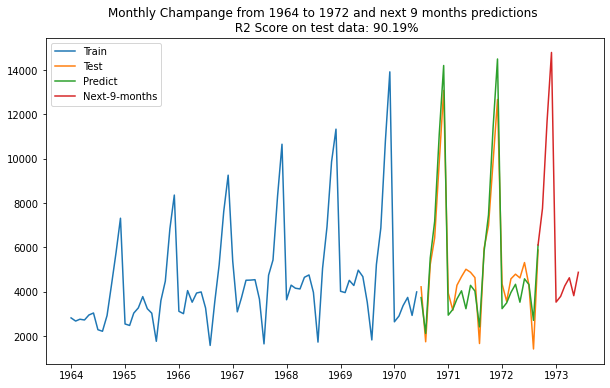

In [32]:
# Trực quan hoá dữ liệu
from sklearn.metrics import r2_score
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Predict')
plt.plot(next_9_months.index, next_9_months, label='Next-9-months')
r2 = r2_score(test, pred)
plt.title('Monthly Champange from 1964 to 1972 and next 9 months predictions \n R2 Score on test data: {:.2f}%'.format(r2*100))
plt.legend(loc='best')
plt.show()

Nhận xét:
- Qua kết quả trực quan hoá và R2 score (90.19%) có thể thấy được model dự đoán rất tốt đối với dữ liệu được cho.
- Tính Seasonal được ARIMA khái quát hoá và predict khá chính xác.